In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

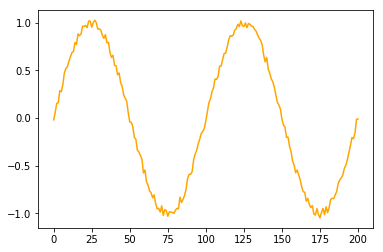

In [3]:
T = 100
f = toy_problem(T)
plt.plot(f, color='orange')
plt.show()

In [4]:
length_of_sequences = 2 * T  # 全時系列の長さ
maxlen = 25  # １つの時系列の長さ

data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

In [5]:
X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

In [6]:
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=N_validation)

# TensorFlowによる実装

In [7]:
def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    cell = tf.contrib.rnn.BasicLSTMCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    state = initial_state
    outputs = []  # 過去の隠れ層の出力を保存
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c  # 線形活性
    return y

In [8]:
def loss(y, t):
    return tf.reduce_mean(tf.square(y-t))

def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    
    train_step = optimizer.minimize(loss)
    return train_step

In [9]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [10]:
n_in = len(X[0][0])
n_hidden = 20
n_out = len(Y[0])

In [11]:
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, shape=[])

In [12]:
y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out=n_out)
loss = loss(y, t)
train_step = training(loss)

In [13]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = N_train // batch_size
early_stopping = EarlyStopping(patience=10, verbose=1)


for epoch in range(epochs):
        X_, Y_ = shuffle(X_train, Y_train)

        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size

            sess.run(train_step, feed_dict={
                x: X_[start:end],
                t: Y_[start:end],
                n_batch: batch_size
                })
            
            val_loss = loss.eval(session=sess, feed_dict={
                x: X_validation,
                t: Y_validation,
                n_batch: N_validation
            })   
            
            # 値を記録しておく
            print('epoch: ', epoch,
                 ' validation loss: ', val_loss)
            
            if early_stopping.validate(val_loss):
                break

epoch:  0  validation loss:  0.52262
epoch:  0  validation loss:  0.518782
epoch:  0  validation loss:  0.514686
epoch:  0  validation loss:  0.510814
epoch:  0  validation loss:  0.506968
epoch:  0  validation loss:  0.502908
epoch:  0  validation loss:  0.498703
epoch:  0  validation loss:  0.49436
epoch:  0  validation loss:  0.489995
epoch:  0  validation loss:  0.485346
epoch:  0  validation loss:  0.48052
epoch:  0  validation loss:  0.475536
epoch:  0  validation loss:  0.470498
epoch:  0  validation loss:  0.465338
epoch:  0  validation loss:  0.459829
epoch:  1  validation loss:  0.454193
epoch:  1  validation loss:  0.448168
epoch:  1  validation loss:  0.441821
epoch:  1  validation loss:  0.435566
epoch:  1  validation loss:  0.429166
epoch:  1  validation loss:  0.422554
epoch:  1  validation loss:  0.41563
epoch:  1  validation loss:  0.408731
epoch:  1  validation loss:  0.401484
epoch:  1  validation loss:  0.394372
epoch:  1  validation loss:  0.387068
epoch:  1  valid

epoch:  15  validation loss:  0.0032179
epoch:  15  validation loss:  0.00279914
epoch:  15  validation loss:  0.0024919
epoch:  15  validation loss:  0.00231451
epoch:  15  validation loss:  0.00225593
epoch:  15  validation loss:  0.00218686
epoch:  15  validation loss:  0.00214063
epoch:  15  validation loss:  0.00216533
epoch:  15  validation loss:  0.00220653
epoch:  15  validation loss:  0.00220185
epoch:  15  validation loss:  0.00215719
epoch:  15  validation loss:  0.00214443
epoch:  15  validation loss:  0.00227634
epoch:  15  validation loss:  0.00240043
epoch:  15  validation loss:  0.00255926
epoch:  16  validation loss:  0.0026757
epoch:  16  validation loss:  0.0026126
epoch:  16  validation loss:  0.0024511
early stopping
epoch:  17  validation loss:  0.00220734
early stopping
epoch:  18  validation loss:  0.00187352
epoch:  18  validation loss:  0.00177281
epoch:  18  validation loss:  0.0017899
epoch:  18  validation loss:  0.00183462
epoch:  18  validation loss:  0.0

epoch:  111  validation loss:  0.00160559
early stopping
epoch:  112  validation loss:  0.00176443
early stopping
epoch:  113  validation loss:  0.00179386
early stopping
epoch:  114  validation loss:  0.00163312
early stopping
epoch:  115  validation loss:  0.00148386
early stopping
epoch:  116  validation loss:  0.0015618
early stopping
epoch:  117  validation loss:  0.00156752
early stopping
epoch:  118  validation loss:  0.00172154
early stopping
epoch:  119  validation loss:  0.00194896
early stopping
epoch:  120  validation loss:  0.00200258
early stopping
epoch:  121  validation loss:  0.00209923
early stopping
epoch:  122  validation loss:  0.00177091
early stopping
epoch:  123  validation loss:  0.00148873
early stopping
epoch:  124  validation loss:  0.00132366
early stopping
epoch:  125  validation loss:  0.00128601
early stopping
epoch:  126  validation loss:  0.0012944
early stopping
epoch:  127  validation loss:  0.00140018
early stopping
epoch:  128  validation loss:  0.

epoch:  240  validation loss:  0.00113842
early stopping
epoch:  241  validation loss:  0.000993752
early stopping
epoch:  242  validation loss:  0.00102137
early stopping
epoch:  243  validation loss:  0.001121
early stopping
epoch:  244  validation loss:  0.00131823
early stopping
epoch:  245  validation loss:  0.00147822
early stopping
epoch:  246  validation loss:  0.0015867
early stopping
epoch:  247  validation loss:  0.00164288
early stopping
epoch:  248  validation loss:  0.0017053
early stopping
epoch:  249  validation loss:  0.00167496
early stopping
epoch:  250  validation loss:  0.00156058
early stopping
epoch:  251  validation loss:  0.00136837
early stopping
epoch:  252  validation loss:  0.00111996
early stopping
epoch:  253  validation loss:  0.000996738
early stopping
epoch:  254  validation loss:  0.000951848
early stopping
epoch:  255  validation loss:  0.000938711
early stopping
epoch:  256  validation loss:  0.000944132
early stopping
epoch:  257  validation loss: 

epoch:  385  validation loss:  0.00118844
early stopping
epoch:  386  validation loss:  0.00122217
early stopping
epoch:  387  validation loss:  0.00123879
early stopping
epoch:  388  validation loss:  0.0011096
early stopping
epoch:  389  validation loss:  0.0010272
early stopping
epoch:  390  validation loss:  0.00105505
early stopping
epoch:  391  validation loss:  0.001143
early stopping
epoch:  392  validation loss:  0.00112708
early stopping
epoch:  393  validation loss:  0.00112108
early stopping
epoch:  394  validation loss:  0.00115012
early stopping
epoch:  395  validation loss:  0.00119895
early stopping
epoch:  396  validation loss:  0.00115164
early stopping
epoch:  397  validation loss:  0.0011031
early stopping
epoch:  398  validation loss:  0.00107319
early stopping
epoch:  399  validation loss:  0.000955126
early stopping
epoch:  400  validation loss:  0.000888524
early stopping
epoch:  401  validation loss:  0.000897096
early stopping
epoch:  402  validation loss:  0.

In [14]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

In [15]:
for i in range(length_of_sequences - maxlen + 1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict={
        x: Z[-1:],
        n_batch: 1
    })
    
    sequence_ = np.concatenate(
    (z_.reshape(maxlen, n_in)[1:], y_), axis=0).reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

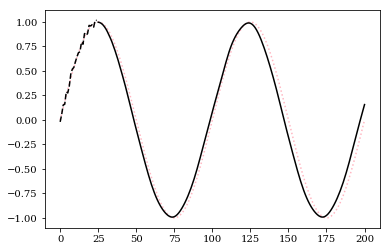

In [16]:
plt.rc('font', family='serif')
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='lightpink')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

# Kerasによる実装

In [17]:
from keras.optimizers import Adam
from keras.layers import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [18]:
def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)

In [19]:
model = Sequential()
model.add(LSTM(n_hidden, init=weight_variable,
                   input_shape=(maxlen, n_in)))
model.add(Dense(n_out, init=weight_variable))
model.add(Activation('linear'))

In [20]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [22]:
epochs = 500
batch_size = 10

model.fit(X_train, Y_train, batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_validation, Y_validation),
         callbacks=[early_stopping])

Train on 158 samples, validate on 18 samples
Epoch 1/500
158/158 [==============================] - 0s 3ms/step - loss: 0.4903 - val_loss: 0.5373
Epoch 2/500
158/158 [==============================] - 0s 709us/step - loss: 0.4707 - val_loss: 0.5031
Epoch 3/500
158/158 [==============================] - 0s 757us/step - loss: 0.3907 - val_loss: 0.3898
Epoch 4/500
158/158 [==============================] - 0s 726us/step - loss: 0.3144 - val_loss: 0.3326
Epoch 5/500
158/158 [==============================] - 0s 710us/step - loss: 0.2628 - val_loss: 0.2839
Epoch 6/500
158/158 [==============================] - 0s 733us/step - loss: 0.2249 - val_loss: 0.2307
Epoch 7/500
158/158 [==============================] - 0s 714us/step - loss: 0.1843 - val_loss: 0.1839
Epoch 8/500
158/158 [==============================] - 0s 752us/step - loss: 0.1461 - val_loss: 0.1385
Epoch 9/500
158/158 [==============================] - 0s 726us/step - loss: 0.1090 - val_loss: 0.0986
Epoch 10/500
158/158 [========

In [23]:
truncate = 25
Z = X[:1]

original = [f[i] for i in range(25)]
predicted = [None for i in range(25)]

for i in range(200 - 25 + 1):
    z_ = Z[-1:]
    y_ = model.predict(z_)
    sequence_ = np.concatenate(
    (z_.reshape(25, n_in)[1:], y_),
    axis=0).reshape(1, 25, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

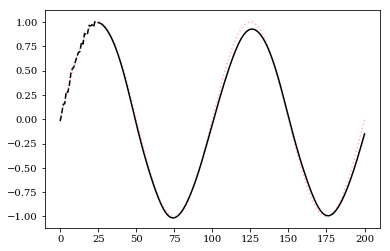

In [24]:
plt.rc('font', family='serif')
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='lightpink')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

# Adding Problem

In [25]:
def mask(T=200):
    mask = np.zeros(T)
    indices = np.random.permutation(np.arange(T))[:2]
    mask[indices] = 1
    return mask

In [26]:
def toy_problem(N=10, T=200):
    signals = np.random.uniform(low=0.0, high=1.0, size=(N, T))
    masks = np.zeros((N, T))
    for i in range(N):
        masks[i] = mask(T)
        
    data = np.zeros((N, T, 2))
    data[:, :, 0] = signals[:]
    data[:, :, 1] = masks[:]
    target = (signals * masks).sum(axis=1).reshape(N, 1)
    
    return (data, target)

In [27]:
N = 10000
T = 200
maxlen = T

X, Y = toy_problem(N=N, T=T)

N_train = int(N * 0.9)
N_validation = N - N_train

n_in = len(X[0][0])  # 2
n_hidden = 100
n_out = len(Y[0])  # 1

In [28]:
model = Sequential()
model.add(LSTM(n_hidden, init=weight_variable,
                   input_shape=(maxlen, n_in)))
model.add(Dense(n_out, init=weight_variable))
model.add(Activation('linear'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=optimizer)
early_stopping = EarlyStopping(monitor='loss', patience=100, verbose=1)

epochs = 10
batch_size = 100

hist = model.fit(X, Y, batch_size=batch_size,
         epochs=epochs,
         callbacks=[early_stopping])

Epoch 1/10
10000/10000 [==============================] - 24s 2ms/step - loss: 0.2882
Epoch 2/10
10000/10000 [==============================] - 24s 2ms/step - loss: 0.1657
Epoch 3/10
10000/10000 [==============================] - 24s 2ms/step - loss: 0.1656
Epoch 4/10
10000/10000 [==============================] - 24s 2ms/step - loss: 0.1656
Epoch 5/10
10000/10000 [==============================] - 24s 2ms/step - loss: 0.1654
Epoch 6/10
10000/10000 [==============================] - 24s 2ms/step - loss: 0.1656
Epoch 7/10
10000/10000 [==============================] - 24s 2ms/step - loss: 0.1656
Epoch 8/10
10000/10000 [==============================] - 24s 2ms/step - loss: 0.1655
Epoch 9/10
10000/10000 [==============================] - 24s 2ms/step - loss: 0.1654
Epoch 10/10
10000/10000 [==============================] - 24s 2ms/step - loss: 0.1652


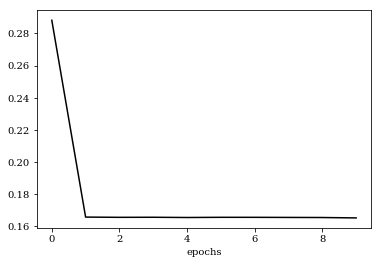

In [29]:
loss = hist.history['loss']

plt.rc('font', family='serif')
fig = plt.figure()
plt.plot(range(len(loss)), loss, label='loss', color='black')
plt.xlabel('epochs')
plt.show()